In [345]:
import torch
from torch import nn, tensor, max, min, sqrt, mean, std, zeros, ones, rand, flatten, cat
from torch import optim
from torch.func import vmap
import tqdm
import matplotlib.pyplot as plt

from dpfuncs import *

dev = torch.device('mps')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, Qv, QDv):
        x = cat((Qv,QDv))
        outs = self.linear_relu_stack(x)
        return outs

In [347]:
model = NeuralNetwork().to(dev)

modelv = vmap(model,in_dims=(1,1))

print(model)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [362]:
n_samples = 1000

model = NeuralNetwork().to(dev)
modelv = vmap(model,in_dims=(1,1))

test_Qv = 1*torch.pi*2*(rand([2,n_samples],device=dev) - 0.5)
test_QDv = 1*torch.pi*2*(rand([2,n_samples],device=dev) - 0.5)
tr = QDD_true_v(test_Qv, test_QDv,m1,m2,l1,l2).to(dev)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

m1 = tensor([1],device=dev)
m2 = tensor([1],device=dev)
l1 = tensor([1],device=dev)
l2 = tensor([1],device=dev)


100%|██████████| 10000/10000 [00:15<00:00, 633.44it/s]


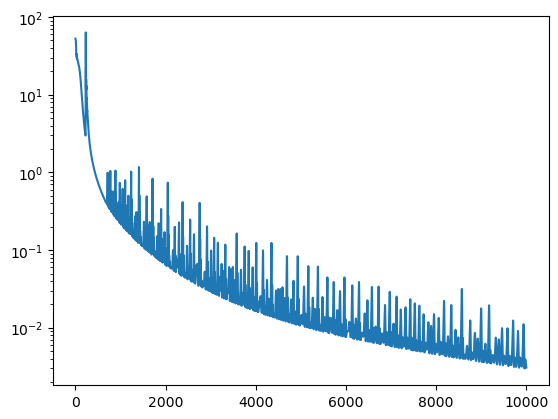

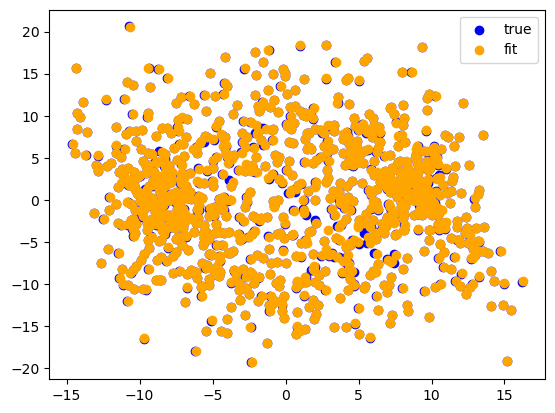

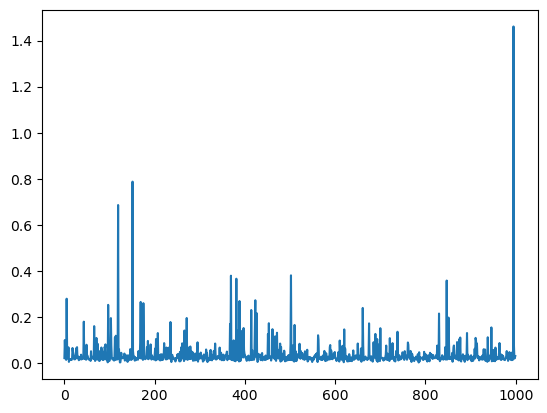

In [363]:
n_epochs = 10000
losses = zeros(n_epochs)


for i in tqdm.trange(n_epochs):
    optimizer.zero_grad()
    data = modelv(test_Qv, test_QDv).mT
    loss = mean( (tr-data)**2 )
    loss.backward()
    optimizer.step()
    losses[i] = loss
    

plt.plot(losses.cpu().detach())
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(tr[0,:].cpu().detach(),tr[1,:].cpu().detach(),color='blue',label='true')
plt.scatter(data[0,:].cpu().detach(),data[1,:].cpu().detach(),color='orange',label='fit')
plt.legend()
plt.show()

#plt.scatter((tr[0,:]-data[0,:]).cpu().detach(),(tr[1,:]-data[1,:]).cpu().detach())
plt.plot( (sqrt((tr[0,:]-data[0,:])**2 + (tr[1,:]-data[1,:])**2).cpu().detach()) )
plt.show()

In [376]:
a = tensor([[1,2],[3,4]],dtype=torch.float,device='mps')
torch.linalg.pinv(a)

tensor([[-2.0000,  1.0000],
        [ 1.5000, -0.5000]], device='mps:0')

In [372]:
torch.linalg.pinv(a)

tensor([[-2.0000,  1.0000],
        [ 1.5000, -0.5000]])